# Data Preparation

## Library

In [ ]:
%%capture
!pip install jcopml
!pip install category_encoders
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

## Load Data

In [ ]:
!gdown 1NJ7DsgZ3zIdZWTz17RQWgbtDBuk1JVg3

Downloading...
From: https://drive.google.com/uc?id=1NJ7DsgZ3zIdZWTz17RQWgbtDBuk1JVg3
To: /content/data_california_house.csv
100% 1.01M/1.01M [00:00<00:00, 61.7MB/s]


In [ ]:
df = pd.read_csv("data_california_house.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


| Fitur              | Deskripsi                                                                 |
|--------------------|---------------------------------------------------------------------------|
| **longitude**|  Ukuran seberapa jauh ke arah barat sebuah rumah di sebelah barat.                                                      |
| **latitude**| Ukuran seberapa jauh ke utara sebuah rumah.                                             |
| **housing_median_age**| Usia rata-rata sebuah rumah dalam satu blok; angka yang lebih rendah adalah bangunan yang lebih baru.                                          |
| **total_rooms**|  Jumlah total kamar tidur dalam satu blok.|
| **population**|  Jumlah total orang yang tinggal di dalam blok.                                        |
| **households**| Jumlah total rumah tangga, sekelompok orang yang tinggal di dalam satu unit rumah, untuk satu blok.                                           |
| **median_income**| Pendapatan rata-rata rumah tangga di dalam satu blok rumah (diukur dalam puluhan ribu Dolar AS).                                       |
| **ocean_proximity**| Lokasi rumah yang dekat dengan samudra/laut.                              |
| **median_house_value**|  Nilai rata-rata rumah untuk rumah tangga dalam satu blok (diukur dalam Dolar AS).           |




Penjelasan tentang isi dari kolom ocean_proximity.

| Isi Data              | Penjelasan                                                                 |
|--------------------|---------------------------------------------------------------------------|
| **ISLAND**|  Ini menunjukkan rumah tersebut terletak di sebuah pulau.                                                      |
| **<1H OCEAN**| Ini menandakan rumah tersebut berjarak kurang dari satu jam dari laut.                                             |
| **NEAR OCEAN**| Rumah tersebut lebih dekat dengan lautan ketimbang `<1H OCEAN.                                          |
| **NEAR BAY**|  Rumah tersebut berada di dekat teluk, yang merupakan perairan yang terhubung ke lautan atau danau.|
| **INLAND**|  Rumah tersebut tidak berada di dekat pantai, melainkan berada di pedalaman.                                        |

# Base Model (Experiment 1) LightGBM R² 0.833118, mae 31199.193982

Mencoba menggunakan 8 model tanpa mengubah apapun dari data ini. Model tersebut adalah :

1. Linear Regression
2. Decision Tree
3. KNN
4. Random Forest
5. Gradient Boosting
6. XGBoost (Xtra Gradient Boosting)
7. Support Vector Machine
8. LightGBM (Light Gradient Boosting Machine)

## Data Split

In [ ]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
numerical_features = X.select_dtypes(include=["number"]).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [ ]:
numerical_features

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'population_per_household', 'bedroom_ratio',
       'income_per_person', 'is_coastal', 'income_level'],
      dtype='object')

In [ ]:
categorical_features

Index(['ocean_proximity', 'house_age_category'], dtype='object')

## Preprocessor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

## Models

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Support Vector Regression": SVR(kernel='rbf'),
    "LightGBM": LGBMRegressor(random_state=42, force_col_wise=True)
}

## Cross Validation

In [ ]:
results = {}

# Define custom scorers
scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'R²': make_scorer(r2_score)
}

# Loop through each model
for model_name, model in models.items():
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Perform cross-validation on training data
    cv_results = {metric: cross_val_score(pipeline, X_train, y_train, cv=5, scoring=scorer).mean()
                  for metric, scorer in scorers.items()}

    # Store the cross-validation results
    results[model_name] = {
        'CV MAE': -cv_results['MAE'],
        'CV MSE': -cv_results['MSE'],
        'CV RMSE': -cv_results['RMSE'],
        'CV R²': cv_results['R²']
    }

# Convert results to a DataFrame
cv_results_df = pd.DataFrame(results).T
cv_results_df = cv_results_df.sort_values(by='CV RMSE', ascending=True)
cv_results_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 207052.135401


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206418.862088


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206880.764031


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 208058.790698


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 207429.319795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 207052.135401


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206418.862088


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206880.764031


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 208058.790698


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 207429.319795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 207052.135401


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206418.862088


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206880.764031


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 208058.790698


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 207429.319795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 207052.135401


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206418.862088


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 21
[LightGBM] [Info] Start training from score 206880.764031


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 208058.790698


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 9159, number of used features: 21
[LightGBM] [Info] Start training from score 207429.319795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,CV MAE,CV MSE,CV RMSE,CV R²
LightGBM,31199.193982,2.252836e+09,47457.644903,0.833118
XGBoost,31748.518337,2.385987e+09,48840.586482,0.823182
Random Forest,33236.216394,2.590290e+09,50892.557702,0.808318
Gradient Boosting,36427.660140,2.822943e+09,53126.940776,0.791144
KNN,42912.295132,3.873563e+09,62231.461501,0.713313
Linear Regression,46503.157213,4.193916e+09,64753.958385,0.689830
Decision Tree,45045.184031,4.998525e+09,70676.681148,0.630606
Support Vector Regression,88968.254889,1.424821e+10,119331.875066,-0.052672


Dari hasil yang kami dapatkan 3 model terbaik adalah :
  1. LightGBM
  2. XGBoost
  3. Random Forest



Mencoba ke Data Test

Kolom di X_train: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household',
       'bedroom_ratio', 'income_per_person', 'is_coastal',
       'house_age_category', 'income_level'],
      dtype='object')
Kolom di X_test: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household',
       'bedroom_ratio', 'income_per_person', 'is_coastal',
       'house_age_category', 'income_level'],
      dtype='object')
Shape X_train: (11448, 16) Shape y_train: (11448,)
Shape X_test: (2863, 16) Shape y_test: (2863,)
Kolom numerik: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'population_per_h

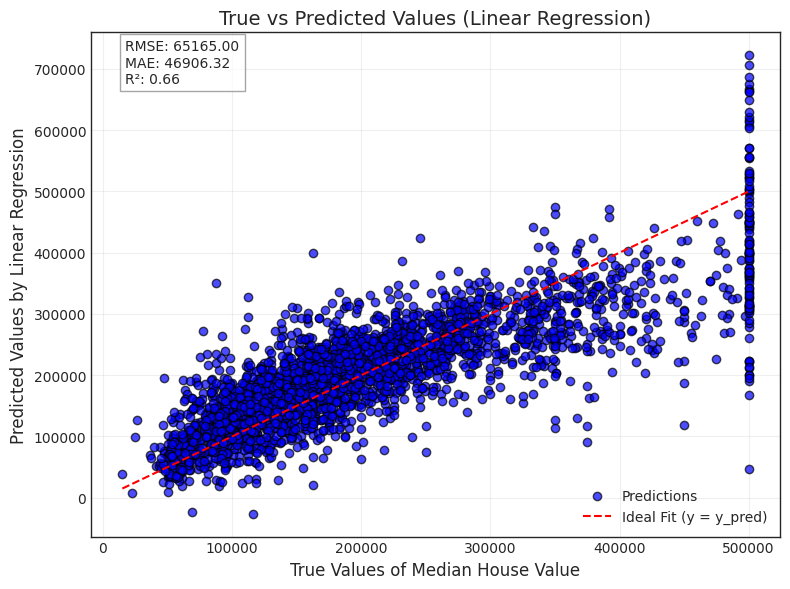

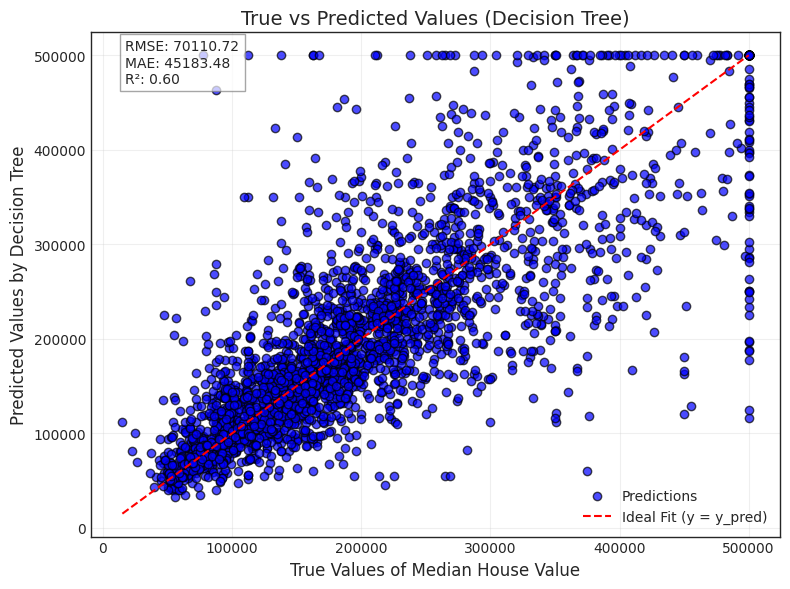

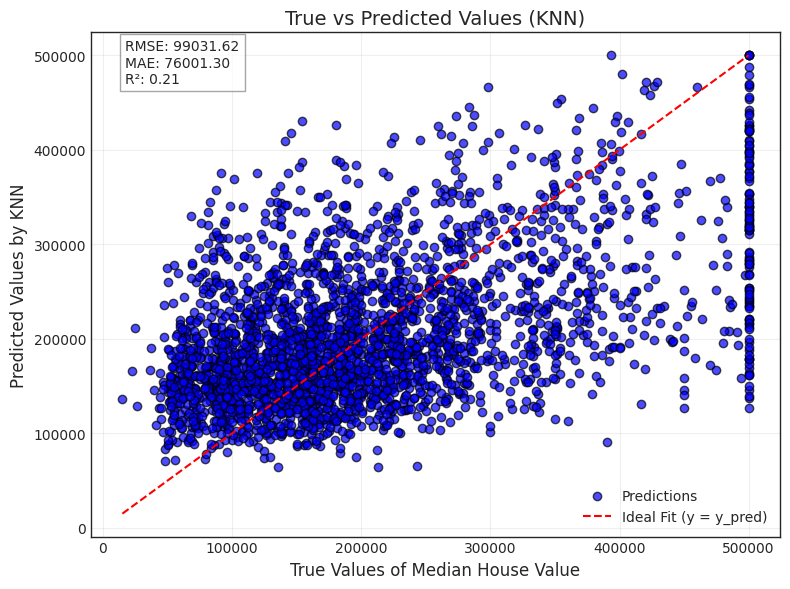

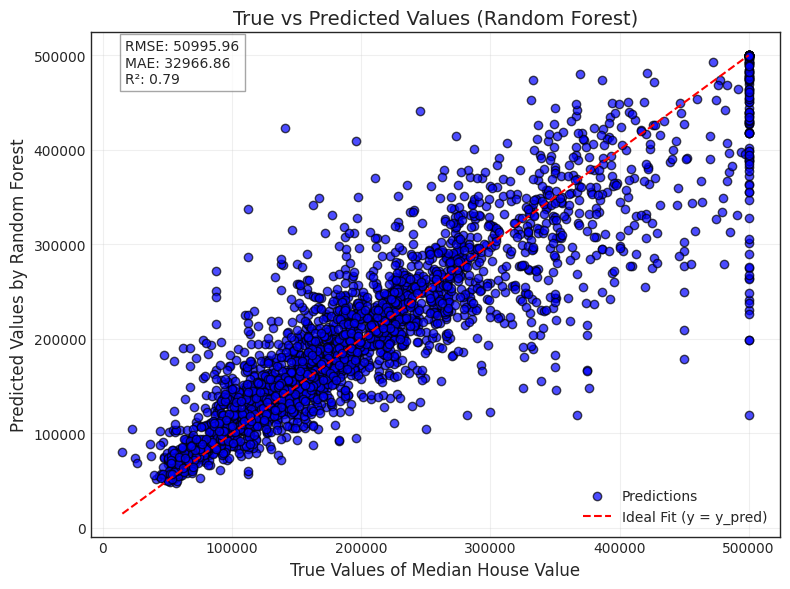

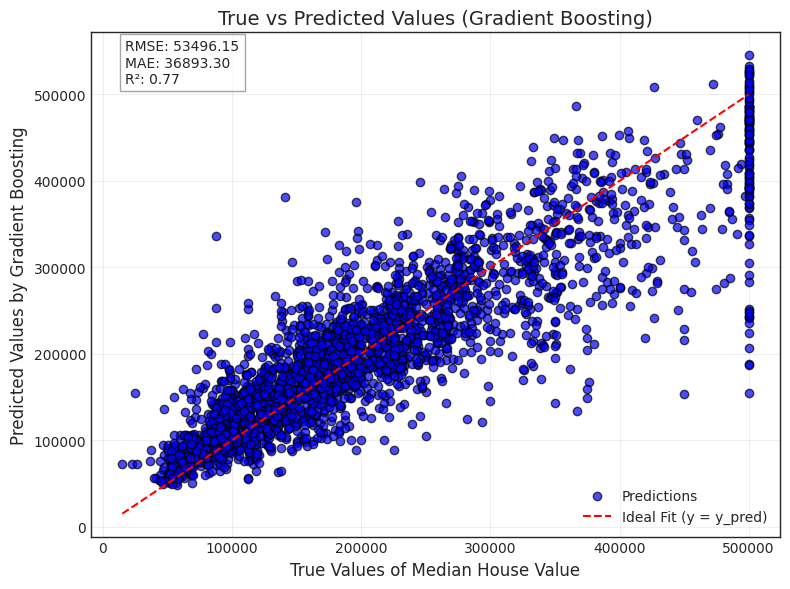

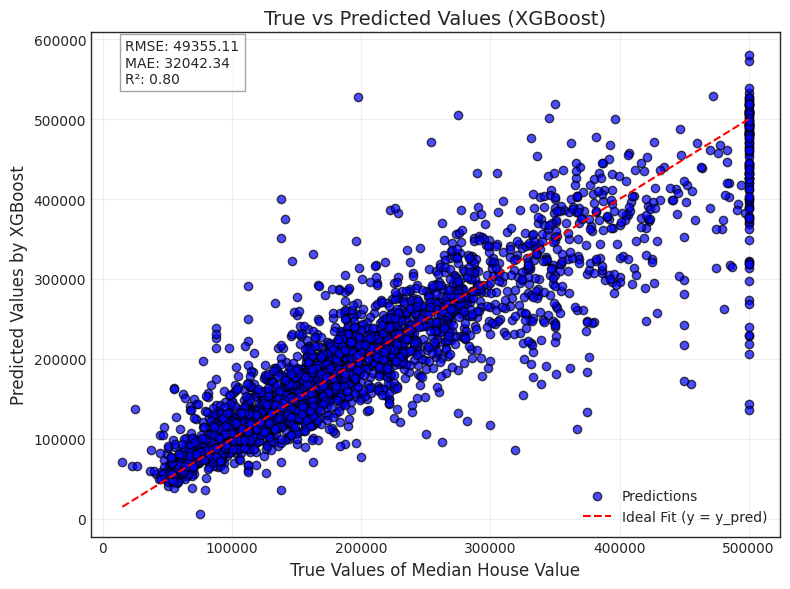

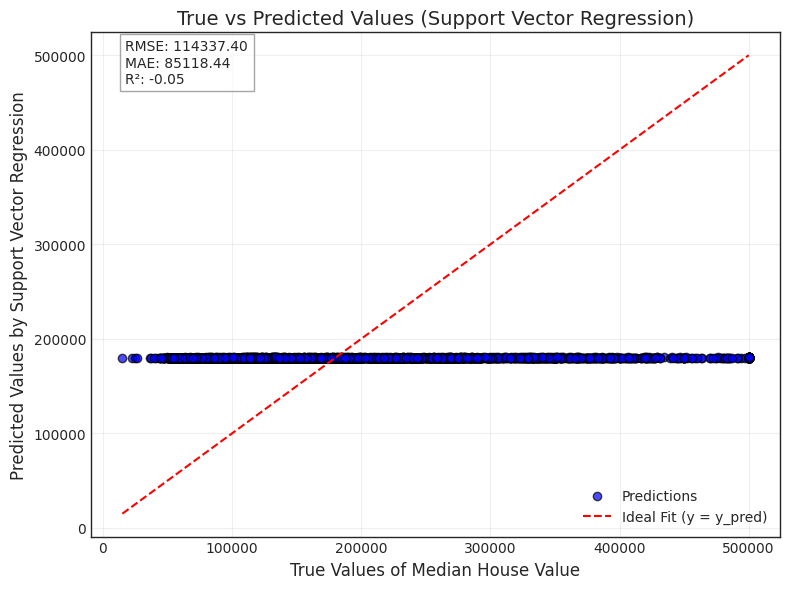

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2877
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 21
[LightGBM] [Info] Start training from score 207167.999563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


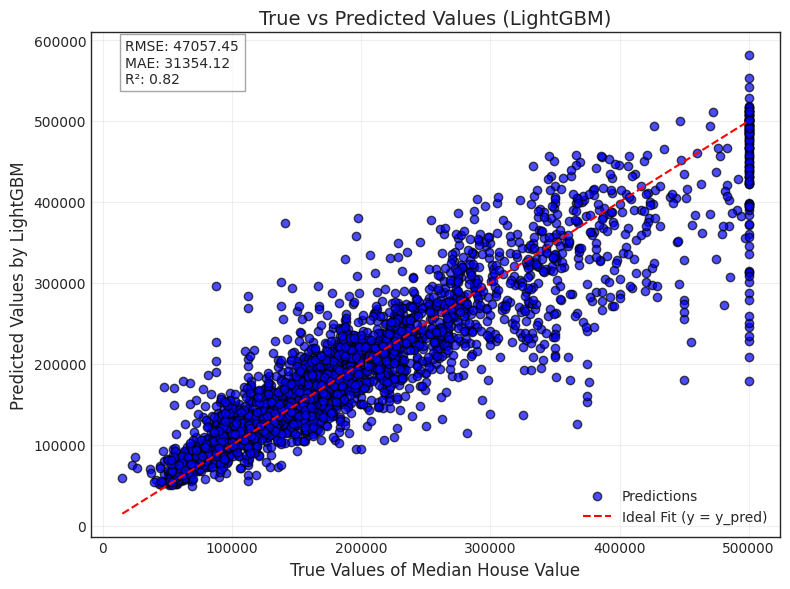

Hasil Evaluasi pada Data Test:
                               Test MAE      Test MSE      Test RMSE   Test R²
LightGBM                   31354.124439  2.214403e+09   47057.446635  0.821931
XGBoost                    32042.336001  2.435927e+09   49355.109276  0.804117
Random Forest              32966.856989  2.600588e+09   50995.960313  0.790876
Gradient Boosting          36893.297930  2.861838e+09   53496.151984  0.769868
Linear Regression          46906.320139  4.246478e+09   65165.004914  0.658524
Decision Tree              45183.483060  4.915514e+09   70110.724768  0.604724
KNN                        76001.298009  9.807262e+09   99031.619313  0.211359
Support Vector Regression  85118.437189  1.307304e+10  114337.398102 -0.051256


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

# Asumsikan Anda memiliki:
# - models: dictionary berisi nama model dan instance model
# - preprocessor: ColumnTransformer yang sudah dikonfigurasi dengan benar
# - X_train, y_train: data pelatihan (X_train tanpa 'median_house_value', y_train adalah 'median_house_value')
# - X_test, y_test: data pengujian (X_test tanpa 'median_house_value', y_test adalah 'median_house_value')

# Periksa kolom di X_train dan X_test
print("Kolom di X_train:", X_train.columns)
print("Kolom di X_test:", X_test.columns)
print("Shape X_train:", X_train.shape, "Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape, "Shape y_test:", y_test.shape)

# Pastikan preprocessor hanya menggunakan kolom yang ada
# Contoh preprocessor (sesuaikan dengan yang Anda gunakan)
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
print("Kolom numerik:", numeric_cols)
print("Kolom kategorikal:", categorical_cols)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False))
        ]), categorical_cols)
    ])

# Inisialisasi dictionary untuk menyimpan hasil evaluasi pada data test
test_results = {}

# Define custom scorers
scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'R²': make_scorer(r2_score)
}

# Loop melalui setiap model
for model_name, model in models.items():
    # Buat pipeline dengan preprocessing dan model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Latih model pada seluruh data train
    pipeline.fit(X_train, y_train)

    # Prediksi pada data test
    y_pred = pipeline.predict(X_test)

    # Hitung metrik evaluasi pada data test
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred)

    # Simpan hasil evaluasi
    test_results[model_name] = {
        'Test MAE': test_mae,
        'Test MSE': test_mse,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    }

    # Visualisasi: Scatter plot untuk true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='k', label='Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit (y = y_pred)')

    # Tambahkan label, judul, dan legenda
    plt.xlabel("True Values of Median House Value", fontsize=12)
    plt.ylabel(f"Predicted Values by {model_name}", fontsize=12)
    plt.title(f"True vs Predicted Values ({model_name})", fontsize=14)
    plt.legend(fontsize=10)

    # Tambahkan metrik ke plot
    plt.text(
        0.05, 0.9,
        f"RMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nR²: {test_r2:.2f}",
        fontsize=10,
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
    )

    # Tampilkan plot
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Konversi hasil test ke DataFrame
test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df.sort_values(by='Test RMSE', ascending=True)

# Tampilkan hasil
print("Hasil Evaluasi pada Data Test:")
print(test_results_df)